In [1]:
import os, re, json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
os.chdir('..')

---

In [150]:
df = pd.read_stata(os.path.join(os.getcwd(), '3_pipeline', '1_intermediate', 'sample_clean.dta'))

In [151]:
# winsorize 1/99 per fyear
winsorized = []

for year in df['fyear'].unique():
    part = df.loc[df['fyear'] == year].copy()
    part['va_w'] = part['va'].clip(lower = part['va'].quantile(0),
                                   upper = part['va'].quantile(0.99))
    winsorized.append(part[['gvkey', 'fyear', 'va_w']])

In [152]:
df = df.merge(right = pd.concat(winsorized), how = 'left', on = ['gvkey', 'fyear'])

<Axes: >

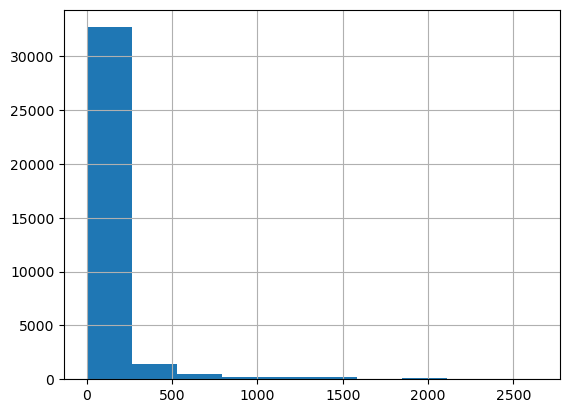

In [153]:
df['va_w'].hist()

In [110]:
df[['ln_va', 'va_d', 'va_w']].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']].reset_index().round(2)

,index,mean,std,min,25%,50%,75%,max
0,ln_va,2.70,2.05,0.0,0.71,2.75,4.25,15.69
1,va_d,0.87,0.34,0.0,1.00,1.00,1.00,1.00
2,va_w,94.88,259.10,0.0,1.04,14.72,69.30,2640.89


In [163]:
df.loc[df['zero_inferred'] == 0, ['cik', 'adsh', 'fyear', 'va']].sample(5)

,cik,adsh,fyear,va
15065,1604868,0001628280-24-010996,2023,49.518
29976,1350593,0001350593-12-000058,2012,49.200
25340,1078271,0001078271-12-000048,2012,140.641
30188,1236275,0001185185-21-000371,2020,0.462
33684,1294924,0001193125-15-204243,2014,5.221


<Axes: xlabel='fyear'>

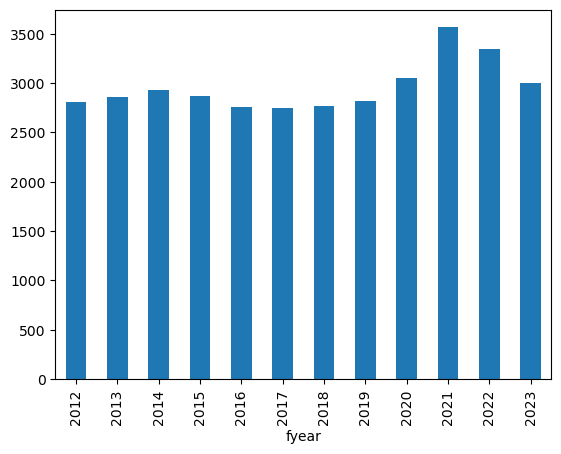

In [55]:
df.groupby('fyear')['gvkey'].count().plot.bar()

<Axes: xlabel='fyear'>

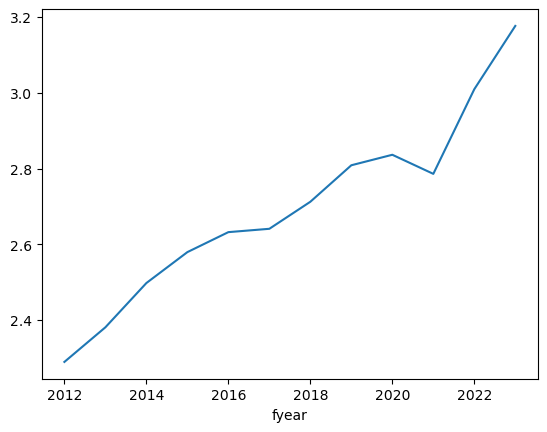

In [56]:
df['ln_va'].groupby(df['fyear']).mean().plot()

<Axes: xlabel='fyear'>

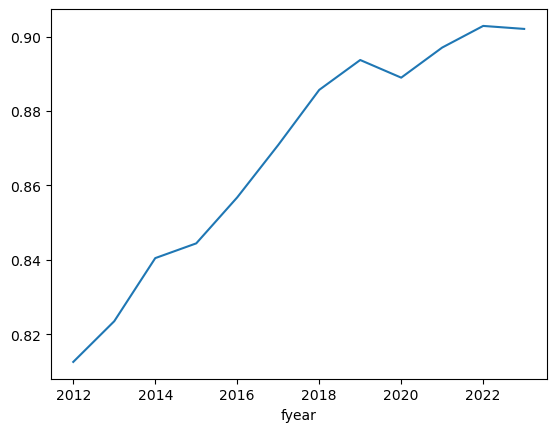

In [57]:
df['va_d'].groupby(df['fyear']).mean().plot()

<Axes: xlabel='fyear'>

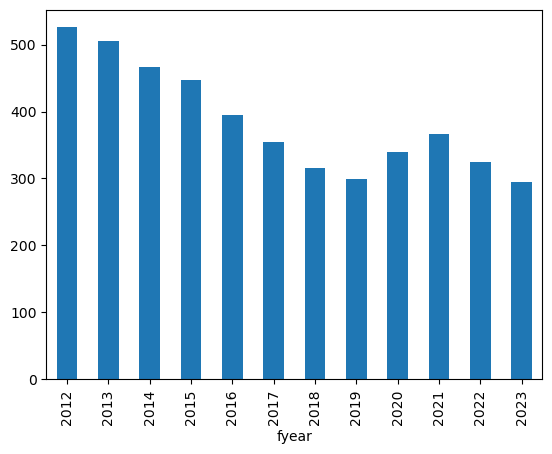

In [58]:
df.loc[df['va'] == 0].groupby('fyear')['gvkey'].count().plot.bar()

In [9]:
# df = df.loc[df['zero_inferred'] == 0]

limit to companies that had a TLCF of zero in 2017

* for those firms, all carryforwards in 2018 or later are indefinite

In [61]:
treat = df.loc[(df['fyear'] == 2017) &
               (df['va'] == 0) &
               (df['tlcf'] == 0), 'gvkey'].unique()

In [63]:
df = df.loc[df['gvkey'].isin(treat)]

In [64]:
df

,gvkey,fyear,cik,adsh,permno,ibes_ticker,fic,sic,va,zero_inferred,...,profit,mtb,lev,cfo,roa,tax,pifo_d,txdfo_d,txfo_d,mne
19,1076.0,2012,706688,0001193125-13-071592,10517.0,ARON,USA,7359.0,0.657,0.0,...,1.0,1.554482,0.078066,0.032960,0.095449,0.057262,0.0,0.0,0.0,0.0
20,1076.0,2013,706688,0000706688-14-000015,10517.0,ARON,USA,7359.0,0.682,0.0,...,1.0,1.550014,0.078101,0.168805,0.066040,0.035188,0.0,0.0,0.0,0.0
21,1076.0,2014,706688,0000706688-15-000089,10517.0,ARON,USA,7359.0,0.706,0.0,...,1.0,1.403948,0.246691,-0.019929,0.031843,0.017694,0.0,0.0,0.0,0.0
22,1076.0,2015,706688,0000706688-16-000237,10517.0,ARON,USA,7359.0,0.752,0.0,...,1.0,1.097371,0.229590,0.062719,0.051040,0.029114,0.0,0.0,0.0,0.0
23,1076.0,2016,706688,0000706688-17-000030,10517.0,ARON,USA,7359.0,0.875,0.0,...,1.0,1.307392,0.190321,0.177940,0.053248,0.030255,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35361,264509.0,2018,1283140,0001283140-19-000007,90253.0,HEPL,USA,4610.0,0.000,1.0,...,1.0,2.228957,0.674850,0.140408,0.085062,0.000012,0.0,0.0,0.0,0.0
35362,264509.0,2019,1283140,0001283140-20-000010,90253.0,HEPL,USA,4610.0,0.000,1.0,...,1.0,1.888671,0.699943,0.135075,0.102256,0.000019,0.0,0.0,0.0,0.0
35363,264509.0,2020,1283140,0001283140-21-000012,90253.0,HEPL,USA,4610.0,0.000,1.0,...,1.0,1.515766,0.683123,0.145614,0.078652,0.000077,0.0,0.0,0.0,0.0
35364,264509.0,2021,1283140,0001283140-22-000009,90253.0,HEPL,USA,4610.0,0.000,1.0,...,1.0,1.598231,0.648301,0.135786,0.099242,0.000015,0.0,0.0,0.0,0.0


<Axes: xlabel='fyear'>

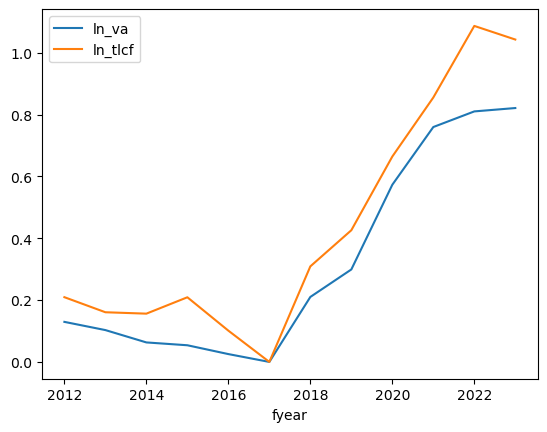

In [65]:
df.groupby('fyear')[['ln_va', 'ln_tlcf']].mean().plot()